# Certificate Program in Quantitative Finance and Risk Management - IIQF
## CAPSTONE PROJECT 2024
### Author: Jillur Rahman

#### LICENSE

> *This work is licensed under **CC BY-NC 4.0**, which means you can copy, modify and share this code as long as you give proper attribution and use it only for non-commercial purposes.*
>
> *Grab the full license here: https://creativecommons.org/licenses/by-nc/4.0/.*

In [1]:
# Import all the necessary libraries
import numpy as np
import datetime as dt
import yfinance as yf
import nsepython as ns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

## 1-2. Value at Risk

### 1. Parametric Value at Risk

Let $r_A(t)$ represent the individual daily percent returns of every symbol $A$ from a set of tickers on any given day $t$. We use the adjusted daily closing prices to compute this quantity.

A portfolio $\Pi$ is defined by a set of weights $\vec{w}=\{w_A\}$. For each $t$, the portfolio return is

$$R_\Pi(t) = \sum_{A} w_A r_A(t)\,.$$

The daily portfolio volatility is given by 

$$s_\Pi(t) = \sqrt{\sum_{A,B} w_A w_B S_{AB}(t)} = \sqrt{{\vec{w}}^T S(t) \vec{w}}$$

where $S(t)$ is the daily covariance matrix, which is assumed to be constant over the entire time range and estimated by time-averaging over the entire time-series data that we have.

Assuming that the portfolio returns are normally distributed with a mean close to zero (which is agreeable only over a small time horizon, otherwise drift corrections must be taken into account), the Value at Risk (VaR) over a period $t$ is estimated with a confidence level $c$ as follows.

$$ \mathrm{VaR}(c,t) = Z_c\, s_\Pi\, \sqrt{t}\, \times \Pi(t)$$

where $Z_c$ is the Z-value corresponding to the confidence level $c$ (e.g. for $c=99$%, $Z_c \simeq 2.33$), and $\Pi(t)$ is the total value of the portfolio.

For longer time sclaes, there might be a non-zero drift $\mu_\Pi$, and a correction must be added.

$$ \boxed{\mathrm{VaR}(c,t) = \left( \mu_\Pi\, t + Z_c\, s_\Pi\, \sqrt{t} \right) \times \Pi(t)}\,. $$

### 2. Historical Value at Risk

The historical VaR at confidence level $c$ is simply the $(1-c)^{\text{th}}$ percentile of the entire historical data at hand.

In [2]:
# Function to fetch data from Yahoo Finance
def fetch_pct_returns(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    return data.pct_change().dropna()

# Function to calculate VaR (in percentage of portfolio value)
def calc_VaR(tickers, weights, start_date, end_date, confidence=0.99, time=1):
    returns   = fetch_pct_returns(tickers, start_date, end_date)
    portf_cov = returns.cov()
    portf_ret = returns @ weights
    drift     = portf_ret.mean() * time
    portf_vol = np.sqrt( weights @ portf_cov @ weights ) * np.sqrt(time)
    z_score   = norm.ppf(confidence)
    
    historical_VaR = -np.percentile(portf_ret, (1-confidence)*100)
    parametric_VaR = (drift + z_score * portf_vol)
    
    return historical_VaR, parametric_VaR

In [3]:
# Portfolio setup
tickers = ['DLF.NS', 'NTPC.NS', 'HDFCBANK.NS']  # Yahoo Finance symbols for DLF, NTPC, HDFC Bank
weights = [0.4, 0.2, 0.4]                       # Portfolio weights
end_date = '2019-10-01'                         # Up to 1st Oct 2019
start_date = (dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=500)).strftime('%Y-%m-%d')
confidence_level = 0.99                         # 99% VaR confidence level
time_horizon = 1                                # Units of time

In [4]:
# Calculate the Value at Risk
histVaR, paramVaR = calc_VaR(tickers, weights, start_date, end_date, confidence_level, time_horizon);

print(f"Parametric VaR (with {confidence_level*100:.0f}% confidence) over {time_horizon} day: {paramVaR*100:.2f}% of initial investment.")
print(f"Historical VaR (with {confidence_level*100:.0f}% confidence) over {time_horizon} day: {histVaR*100:.2f}% of initial investment.")

Parametric VaR (with 99% confidence) over 1 day: 3.51% of initial investment.
Historical VaR (with 99% confidence) over 1 day: 3.57% of initial investment.


## 3. European Option Valuation - Monte Carlo Simulation

The price of an option is the **expected value of its payoff under risk-neutral probabilities**. We simulate thousands (or millions) of future asset price paths using random sampling (stochastic simulations) and then calculate the average payoff of the option at expiry.

The price $S(t)$ at any future time $t$ is modelled by the stochastic differential equation (SDE)

$$ dS = \mu\, S\, dt + \sigma\, S\, dW $$

where $\mu$ is the drift, $\sigma$ is the volatility and $dW$ is the Wiener process (Brownian motion). In a risk-neutral setting, $\mu$ is replaced by the risk-free rate $r$. The evolution equation then turns out to be:

$$ S(t+\delta t) = S(t)\, e^{ \left( r - \frac{\sigma^2}2 \right) \delta t + \sigma \sqrt{\delta t}\, Z } $$

where $Z$ is a random variable from a standard normal distribution $\mathcal N(0,1)$.

Here are the steps we would take to price an European option.

- **Step 1.** We will simulate many price paths for the option (on Nifty) at the expiry date $T$ (in this case, one month from now). We do this by generating random values for $Z$ from a normal distribution.

- **Step 2.** We will calculate the payoff. For a European call option, the payoff at expiry $T$ is $\max(S(T)-K, 0)$, where $S(T)$ is the simulated price of the option at expiry and $K$ is the strike price. For a European put option, the payoff is $\max(K-S(T),0)$.

- **Step 3.** The price of the option is the expected value of the discounted payoffs:
$$ \text{Option Price} = e^{-rT} \langle\, \text{Payoff}\, \rangle $$
where $\langle \cdot \rangle$ indicates an average over all simulations, and $r$ is the risk-free interest rate.

In [5]:
# Function to grab a call and put option from the National Stock Exchange of India
def fetch_NSE_option_expiring_in_a_month(symbol):
    NSE_optionchain    = ns.nse_optionchain_scrapper(symbol)

    # Find the options with the appropriate expiry date
    available_expiries = ns.expiry_list(symbol)
    today              = dt.date.today()
    one_month_later    = today + dt.timedelta(days=30)
    expiry_date        = min(available_expiries, key=lambda date: 
                             abs(dt.datetime.strptime(date, "%d-%b-%Y").date() - one_month_later))
    options            = [ option for option in NSE_optionchain['records']['data'] 
                           if option['expiryDate'] == expiry_date ]

    # Pick a put and call option with the same strike
    chosen_one = None
    for option in options:
        if 'CE' in option and 'PE' in option:
            if option['CE']['lastPrice'] !=0 and option['PE']['lastPrice'] !=0 and \
               option['CE']['impliedVolatility'] !=0 and option['PE']['impliedVolatility'] !=0:
                chosen_one = option
                break

    return chosen_one

# Monte-Carlo simulation of option price based on a stochastic evolution of the underlying price
def simulateOptionPrice(spot, strike, maturity, vol, riskFreeRate, num_sims, num_steps=500, optType='put'):
    # Check if the correct type has been specified
    if optType not in ['put', 'call']:
        raise ValueError(f"Invalid optType: {optType}. Must be 'put' or 'call'.")

    # No need to simulate randomness if volatility is zero (deterministic evolution)
    if vol==0:
        present_val_of_strike = np.exp(-riskFreeRate*maturity) * strike
        intrinsic_value = (present_val_of_strike - spot) if optType=='put' else (spot - present_val_of_strike)
        return np.maximum(intrinsic_value, 0)
        
    # Set up the stochastic evolution
    time_step    = maturity / num_steps                                 # Step size
    random_kicks = np.random.normal(0,1,(num_sims,num_steps))           # Normally distributed random numbers
    coeffs       = np.exp( (riskFreeRate-vol**2/2)*time_step            # Evolution operator
                          + vol*np.sqrt(time_step)*random_kicks )
    S_paths      = np.zeros((num_sims, num_steps))                      # Allocate space for the ensemble of paths
    S_paths[:,0] = spot                                                 # Initial condition
    
    # Run the evolution equation to get all the price paths
    for t in range(1, num_steps):
        S_paths[:,t] = S_paths[:,t-1] * coeffs[:,t]

    # Compute the payoff and discount it to the present
    intrinsic_value_on_maturity = (strike - S_paths[:,-1]) if optType=='put' else (S_paths[:,-1] - strike)
    payoff = np.maximum(intrinsic_value_on_maturity, 0).mean()
    price  = np.exp(-riskFreeRate*maturity) * payoff
    
    return price

# Function to compare prices and decide whether to buy/sell
def compare(simulated_price, market_price):
    if simulated_price > market_price:
        print("Option is undervalued. Consider buying.")
    elif simulated_price < market_price:
        print("Option is overvalued. Consider selling.")
    else:
        print("Option is fairly valued.")

In [6]:
# Choose your favorite underlying and fetch calls and puts
symbol = 'NIFTY'
nifty  = fetch_NSE_option_expiring_in_a_month(symbol)

In [7]:
# Set up the simulation parameters
K    = nifty['strikePrice']                 # Strike Price
S    = nifty['PE']['underlyingValue']       # Spot Price (today)
sPut = nifty['PE']['impliedVolatility']/100 # Impl. Vol. of PUT
sCal = nifty['CE']['impliedVolatility']/100 # Impl. Vol. of CALL
T    = nifty['expiryDate']                  # Time to expiry (in years)
T    = (dt.datetime.strptime(T, '%d-%b-%Y').date() - dt.date.today()).days / 365
r    = 0.0675                               # Risk-free rate of return (p.a.) from India 10-Year Bond
Nsims  = 100000                             # Number of price paths simulated
Nsteps = 500                                # Number of steps to reach expiry

# Print the values for diagnostic information
print(f"Spot price     = {S:>8.2f} INR.")
print(f"Strike price   = {K:>8.2f} INR.")
print(f"Time to expiry = {T:.2f} years.")
print(f"Put impl. vol. = {sPut*100}%.")
print(f"Call impl. vol.= {sCal*100}%.")
print(f"Risk-free rate = {r*100}% p.a.")

Spot price     = 25810.85 INR.
Strike price   = 22250.00 INR.
Time to expiry = 0.08 years.
Put impl. vol. = 26.06%.
Call impl. vol.= 36.33%.
Risk-free rate = 6.75% p.a.


In [8]:
# Run the Monte Carlo sims to estimate the price of the options
sim_price_put  = simulateOptionPrice( spot=S,
                                      strike=K,
                                      maturity=T,
                                      vol=sPut,
                                      riskFreeRate=r,
                                      num_sims=Nsims,
                                      optType='put' )
sim_price_call = simulateOptionPrice( spot=S,
                                      strike=K,
                                      maturity=T,
                                      vol=sCal,
                                      riskFreeRate=r,
                                      num_sims=Nsims,
                                      optType='call' )
mkt_price_put  = nifty['PE']['lastPrice']
mkt_price_call = nifty['CE']['lastPrice']

In [9]:
# Print the results
print(f"Simulated price of put  = {sim_price_put:>7.2f} INR.")
print(f"Market price of put     = {mkt_price_put:>7.2f} INR.")
print(f"Simulated price of call = {sim_price_call:>7.2f} INR.")
print(f"Market price of call    = {mkt_price_call:>7.2f} INR.")

Simulated price of put  =   12.86 INR.
Market price of put     =   12.85 INR.
Simulated price of call = 3759.02 INR.
Market price of call    = 3826.00 INR.


In [10]:
print("Comparing the prices of the PUT...")
compare(sim_price_put, mkt_price_put)
print("\nComparing the prices of the CALL...")
compare(sim_price_call, mkt_price_call)

Comparing the prices of the PUT...
Option is undervalued. Consider buying.

Comparing the prices of the CALL...
Option is overvalued. Consider selling.


## 4. Price Value of A Basis Point for a Putable Bond

### Valuation of a Putable Bond

A putable bond is a bond with an *embedded put* option giving the holder the right but not the obligation to “put” the bond back to the issuer, usually at par, before maturity. Let's assume we are dealing with an European embedded option, meaning that the option has to be exercised, if desired, on a single date of expiry.

In the absence of arbitrage, the price of a putable bond, $V_{\text{putable}}$, is the sum of its parts: namely, the price of the underlying straight bond (the same bond but just without the embedded put), $V_{\text{straight}}$, plus the price of the isolated put option, $V_{\text{put}}$.

$$ V_{\text{putable}} = V_{\text{straight}} + V_{\text{put}} $$

In the absence of credit risk, the value of the straight bond is simply the present value of future cashflows from coupon payments and principal repayment. Assuming annual coupon payments and discounting with annually compounded spot rates, we have

$$ V_{\text{straight}} = \sum_{t=1}^{T-1} \frac{C}{(1+r_t)^t} + \frac{C+F}{(1+r_T)^T}\,,$$

where $C$ is the coupon payment, $F$ is the face (or par) value, $r_t$ is the spot rate at time $t$ (in years), and $T$ is the maturity (in years). Or, in terms of forward rates, this is rewritten as

$$ V_{\text{straight}} = \sum_{t=1}^{T-1} \frac{C}{\Pi_{k=0}^{t-1} (1+F_{k,1})} + \frac{C+F}{\Pi_{k=0}^{T-1} (1+F_{k,1})}\,, $$

where $F_{k,1}$ is the “1-year forward rate $k$ years from now.” These are defined using the no-arbitrage principle,

$$ (1+r_k)^k\, (1+F_{k,1}) = (1+r_{k+1})^{k+1}\,, $$

which says that investing for $k$ years at the interest rate $r_k$ and then investing for 1 year at the rate $F_{k,1}$ is exactly equivealent to investing for $k+1$ years at the rate $r_{k}+1$. Solving the above for $F_{k,1}$ is straightforward.

Using the forward rates allows us to start in the final year and discount back the cashflows one year at a time until we reach the present value. The additional advantage to this method is that it allows for the tracking of put/call conditions easily, because we are looking at one year at a time. For the putable bond, for example, the discounted value of future cashflows in the exercise year is compared with the face value of the bond and the maximum of the two is chosen. Then we continue with the backwards induction until we reach the present value, which is the required price of the bond.

#### Calculation of forward/spot rates

If we are given a sequence of par rates (coupon rates of bonds selling at par), $\{P_1, P_2, \ldots, P_t\}$, corresponding to different maturities $t$, then the spot rates $\{r_1, r_2, \ldots, r_t\}$ can be solved for by bootstrapping, that is recursively solving the defining equation of par rates for progressively longer maturities:

$$  \sum_{j=1}^{t-1} \frac{P_t}{(1+r_j)^j} + \frac{1 + P_t}{(1+r_t)^t} = 1\,. $$

Alternatively, one could model the spot rates after some real-world interest rate curve. The exercise suggests something along the lines of using LIBOR curves for the past 30 years to do this. However, LIBOR is being phased out at the moment, and unfortunately, many free libraries (e.g. Yahoo Finance) do not directly provide historical LIBOR rates.

Instead, we could follow the U.S. 10-year Treasury (`^TNX`) yield, which can be a proxy for interest rates. Having collected a time-series of rates from Yahoo Finance for the maximum amount of time possible, we use this to extrapolate a naive future projection, which is an exponential decay function. It is a toy model, just for illustrative purposes. We can then use these projections as spot rates in the computation of bond prices.

### The “Dollar Value” of 0.01% (DV01)

It is the amount by which the price of a bond changes in response to a 0.01% or 1 basis point of fluctuation in the spot rates.

$$ \text{DV01} = V_{\text{putable}}(r_k) - V_{\text{putable}}(r_k - 0.01\% r_k)$$

In [11]:
# Function to calculate the spot rates as a function of the maturity period
def calc_spotRate(year, parRates, savedSpotRates=[None]):
    # Check if the year is invalid
    if year < 1:
        raise ValueError(f"Invalid year: {year}. Must be at least 1.")
        
    # Check if parRates is a sequence of appropriate length
    if len(parRates) < year:
        raise ValueError(f"The number of par rates supplied ({len(parRates)} is insufficient.")
    
    # Initialise memorisation record
    if savedSpotRates is None or len(savedSpotRates)==0:
        raise ValueError("savedSpotRates must be a non-empty list.")
    elif savedSpotRates[0] != parRates[0]:
        savedSpotRates[0] = parRates[0]                 # one-year spot rate = one-year par rate
    if len(savedSpotRates) < year:
        savedSpotRates.extend([None] * (year-len(savedSpotRates)))

    # Answer from memory
    if savedSpotRates[year-1] is not None:
        return savedSpotRates[year-1]

    # Solve for the spot rate recursively
    parRate  = parRates[year-1]
    discount = sum(1 / (1+calc_spotRate(t, parRates, savedSpotRates))**t for t in range(1, year))
    answer   = ( (1+parRate) / (1-parRate*discount) )**(1/year) - 1

    # Save the spot rate in the provided dictionary
    savedSpotRates[year-1] = answer

    return answer

# Function to price straight bonds using provided spot rates
def price_straightBond_spt(parValue, coupon, maturity, spotRate):
    price = sum( coupon / (1+spotRate[t-1])**t for t in range(1, maturity) ) + \
            (coupon+parValue) / (1+spotRate[maturity-1])**maturity
    
    return price

# Function to price straight bonds using forward rates and backwards induction
def price_straightBond_fwd(parValue, coupon, maturity, spotRate):
    # Calculate 1-year forward rates
    fwdRate    = [ (1+spotRate[t])**(t+1) / (1+spotRate[t-1])**t - 1 for t in range(maturity) ]
    fwdRate[0] = spotRate[0]

    # Start with the final cash flow at T (coupon + face value)
    price = coupon + parValue

    # Backward induction: discount cash flows one year at a time
    for t in range(maturity-1, 0, -1):
        price = coupon + (price / (1+fwdRate[t]))

    # Finally, discount the first cash flow (coupon at year 1)
    price /= (1+fwdRate[0])
    
    return price

# Function to price putable bonds using forward rates and backwards induction
def price_embeddedBond(parValue, coupon, maturity, spotRate, exerciseYears, strike=None, optType='put'):
    # Check if the correct type has been specified
    if optType not in ['put', 'call']:
        raise ValueError(f"Invalid optType: {optType}. Must be 'put' or 'call'.")
    if strike is None:
        strike = parValue           # option to redeem at par by default

    # Calculate 1-year forward rates
    fwdRate    = [ (1+spotRate[t])**(t+1) / (1+spotRate[t-1])**t - 1 for t in range(maturity) ]
    fwdRate[0] = spotRate[0]

    # Start with the final cash flow at T (coupon + face value)
    price = coupon + parValue

    # Backward induction: discount cash flows one year at a time
    for t in range(maturity-1, 0, -1):
        futureValue = price / (1+fwdRate[t])
        if t in exerciseYears:
            optVal = max(strike, futureValue) if optType=='put' else min(strike, futureValue)
            price  = coupon + optVal
        else:
            price  = coupon + futureValue

    # Finally, discount the first cash flow (coupon at year 1)
    price /= (1+fwdRate[0])
    
    return price

# Function to calculate the price value of a basis point for a bond with an embedded option
def dv01_embeddedBond(parValue, coupon, maturity, spotRates, exerciseYears, optType='put'):
    # Shift spot rates down by 1 basis point (0.0001)
    shifted_spotRates = [r - 0.0001 for r in spotRates]

    # Calculate the difference in bond prices due to the 0.01% shift in spot rates
    dv01 =  price_embeddedBond(parValue, coupon, maturity, shifted_spotRates, exerciseYears, optType=optType) \
          - price_embeddedBond(parValue, coupon, maturity, spotRates,         exerciseYears, optType=optType)

    return dv01

In [12]:
# Let's take an example bond
parValue = 100
coupon   = 4.25
maturity = 3
exrYears = [1, 2]       # Exercise years for the variant with embedded option

# We assume that par rates grow linearly year by year for this toy model
parRates = [ 0.025 + j*0.005 for j in range(maturity) ]

# Let's calculate all the spot rates
spotRate = [None]
calc_spotRate( year=maturity,
               parRates=parRates,
               savedSpotRates=spotRate )

# Let's calculate the prices
price_spot = price_straightBond_spt(parValue, coupon, maturity, spotRate)
price_frwd = price_straightBond_fwd(parValue, coupon, maturity, spotRate)
price_putl = price_embeddedBond(parValue, coupon, maturity, spotRate, exrYears, optType='put')
price_call = price_embeddedBond(parValue, coupon, maturity, spotRate, exrYears, optType='call')
DV01_putl  = dv01_embeddedBond(parValue, coupon, maturity, spotRate, exrYears, optType='put')
DV01_call  = dv01_embeddedBond(parValue, coupon, maturity, spotRate, exrYears, optType='call')

print(f"Bond with a Par Value of €{parValue}, coupon rate of {coupon}%, maturity in {maturity} years:")
print(f"    Price calculated from spot rates:        \t €{price_spot:7.3f}.")
print(f"    Price calculated from forward rates:     \t €{price_frwd:7.3f}.")
print(f"    Price of putable at par in {exrYears} years:\t €{price_putl:7.3f}.")
print(f"    Price of callable at par in {exrYears} years:\t €{price_call:7.3f}.")
print(f"    DV01 of putable at par in {exrYears} years:\t €{DV01_putl:7.3f}.")
print(f"    DV01 of callable at par in {exrYears} years:\t €{DV01_call:7.3f}.")

Bond with a Par Value of €100, coupon rate of 4.25%, maturity in 3 years:
    Price calculated from spot rates:        	 €102.115.
    Price calculated from forward rates:     	 €102.115.
    Price of putable at par in [1, 2] years:	 €102.398.
    Price of callable at par in [1, 2] years:	 €101.707.
    DV01 of putable at par in [1, 2] years:	 €  0.019.
    DV01 of callable at par in [1, 2] years:	 €  0.010.


**Note:** The putable bond is sold at a *premium* to a bond without optionability since if interest rates are expected to rise, the put option protects the bondholder. Alternatively, callable options are sold at a *discount* since it protects the issuer.

#### Naive Interest Rate Extrapolation

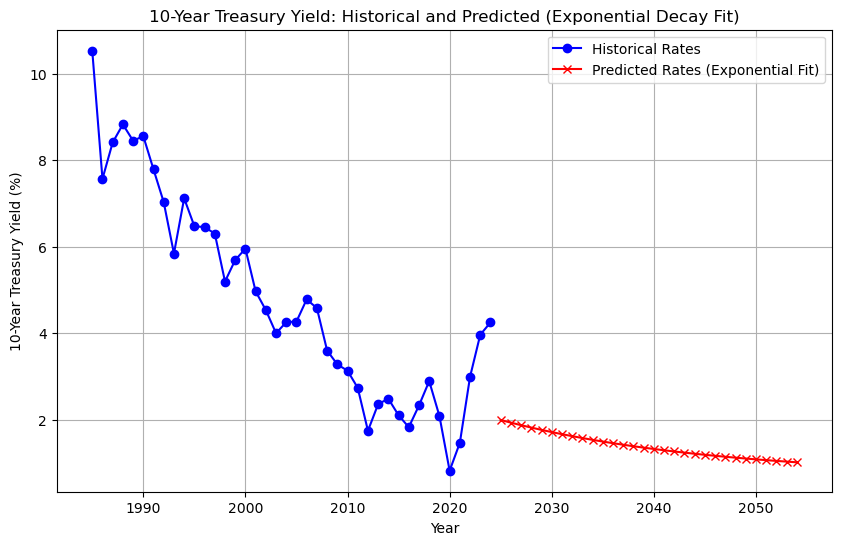

In [13]:
# Sample the data
data_intRates = yf.download('^TNX', period='max', interval='1mo', progress=False)['Adj Close']\
                  .resample('YE').mean()
years = np.array([date.year for date in data_intRates.index])
rates = data_intRates.values

# Try an exponential decay function as a fit
def exp_decay(t, a, b, c):
    return a * np.exp(b * t) + c

# Fit the data
years_normalised   = years - years.min()
initial_guess      = [4, -0.03, 1]
params, covariance = curve_fit(exp_decay, years_normalised, rates, p0=initial_guess)
a, b, c            = params

# Project future interest rates (next 30 years)
future_years = np.array([year for year in range(years[-1] + 1, years[-1] + 31)])
future_years_normalised = future_years - years.min()
future_rates = exp_decay(future_years_normalised, a, b, c)

# Plot the fit
plt.figure(figsize=(10, 6))
plt.plot(years, rates, label='Historical Rates', color='blue', marker='o')
plt.plot(future_years, future_rates, label='Predicted Rates (Exponential Fit)', color='red', marker='x')
plt.xlabel('Year')
plt.ylabel('10-Year Treasury Yield (%)')
plt.title('10-Year Treasury Yield: Historical and Predicted (Exponential Decay Fit)')
plt.legend()
plt.grid(True)
plt.show()

#### Example bond given in the exercise

To be honest, it's not a great example to illustrate the point of putable bonds or their volatility.

In [14]:
# Bond specification
parValue = 1000
coupon   = 7.65/100 * parValue
maturity = 30
exrYears = [15]

# Let's calculate the prices
spotRates      = future_rates/100
price_straight = price_straightBond_spt(parValue, coupon, maturity, spotRates)
price_putable  = price_embeddedBond(parValue, coupon, maturity, spotRates, exrYears, optType='put')
DV01_putable   = dv01_embeddedBond(parValue, coupon, maturity, spotRates, exrYears, optType='put')

print(f"Bond with a Par Value of €{parValue}, coupon rate of {coupon*100/parValue}%, maturity in {maturity} years:")
print(f"    Price of straight bond with same specs: \t €{price_straight:7.3f}.")
print(f"    Price of putable at par in {exrYears} years:\t €{price_putable:7.3f}.")
print(f"    DV01 of putable at par in {exrYears} years:\t €{DV01_putable:8.3f}.")

Bond with a Par Value of €1000, coupon rate of 7.65%, maturity in 30 years:
    Price of straight bond with same specs: 	 €2643.389.
    Price of putable at par in [15] years:	 €2643.389.
    DV01 of putable at par in [15] years:	 €   4.985.


Maximum exposure (DV01) for the puttable bond will likely occur before the 15-year put date, when the bond still behaves like a long-term (30-year) bond, making it more sensitive to interest rate changes.